In [1]:
import gzip
import json
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import sys 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# EDA

In [2]:
# import basic cell data informaiton for the xbar datasets
with gzip.open('data/NCSU-DigIC-GraphData-2023-07-25/cells.json.gz','rb') as f:
    cells_data = json.loads(f.read().decode('utf-8'))

cells_data

FileNotFoundError: [Errno 2] No such file or directory: 'NCSU-DigIC-GraphData-2023-07-25/cells.json.gz'

In [3]:
# Helping method for BST
def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

# Helping method to get the GRC index given cell x location and y location
def getGRCIndex(x,y,xbst,ybst):
    while (type(xbst)==tuple):
        if x < xbst[0]:
            xbst=xbst[1]
        else:
            xbst=xbst[2]
            
    while (type(ybst)==tuple):
        if y < ybst[0]:
            ybst=ybst[1]
        else:
            ybst=ybst[2]
            
    return ybst, xbst

## Single dataset EDA (xbar1)

In [5]:
with gzip.open('data/NCSU-DigIC-GraphData-2023-07-25/xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))

# Important info for further analysis 
instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])
conn=np.load('data/NCSU-DigIC-GraphData-2023-07-25/xbar/1/xbar_connectivity.npz')
congestion_data = np.load('data/NCSU-DigIC-GraphData-2023-07-25/xbar/1/xbar_congestion.npz')
xbst=buildBST(congestion_data['xBoundaryList'])
ybst=buildBST(congestion_data['yBoundaryList'])

In [6]:
instances

,name,id,xloc,yloc,cell,orient
0,clk_gate_out_reg/latch,0,41984,44544,23,0
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0
...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4
3948,U4125,3948,33664,66048,42,0
3949,U4128,3949,23296,66048,34,0
3950,ZCTSBUF_205_132,3950,40576,44544,11,0


The `instances` dataframe comprises 6 columns: `name`, `id`, `xloc`, `yloc`, `cell`, and `orient`. Our objective is to integrate congestion information for each cell, calculated as the disparity between demand and capacity. Specifically, Congestion = Demand - Capacity.

In [7]:
congestion = congestion_data['demand'] - congestion_data['capacity']
congestion

array([[[-15, -12, -12, ..., -12,  -5, -13],
        [ -2,   0,   0, ...,   0,   0,  -2],
        [ -1,   0,   0, ...,   0,   0,  -2],
        ...,
        [ -2,   0,   0, ...,   0,   0,  -2],
        [ -2,   0,   0, ...,   0,   0,  -2],
        [ -3,   0,   0, ...,   0,   0,  -2]],

       [[ -9,  -9,  -6, ...,  -8,  -9,  -9],
        [ -5,  -4,  -5, ...,  -6,  -4,  -6],
        [ -3,  -2,  -1, ...,  -6,  -4,  -7],
        ...,
        [ -3,  -3,  -1, ...,  -4,  -3,  -6],
        [ -9,  -6,  -1, ...,  -5,  -3,  -6],
        [-12, -11, -10, ..., -11, -10, -10]],

       [[-13, -12,  -7, ..., -11,  -5, -13],
        [ -8,  -8,  -5, ..., -10,  -3, -13],
        [ -6,  -6,  -4, ...,  -9,   2,   1],
        ...,
        [ -7,  -5,  -6, ...,  -9, -11, -13],
        [-10,  -5,  -7, ..., -11,  -3, -13],
        [-15, -11, -11, ..., -12,  -4, -14]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0

In [53]:
congestions = np.zeros(shape = [instances.shape[0],])
demand = np.zeros(shape = [instances.shape[0],])
capacity = np.zeros(shape = [instances.shape[0],])
grcX = np.zeros(shape = [instances.shape[0],])
grcY = np.zeros(shape = [instances.shape[0],])

max_index = 0
max_congestion = 0

for k in range(instances.shape[0]):
    xloc = instances.iloc[k]['xloc']
    yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    d = 0
    c = 0
    cong = 0
    
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
        c += congestion_data['capacity'][lyr][i][j]
        cong += congestion_data['demand'][lyr][i][j] - congestion_data['capacity'][lyr][i][j]
    
    if cong > max_congestion:
        max_congestion = cong
        max_index = (i,j)

    grcX[k] = i
    grcY[k] = j    
    demand[k] = d
    capacity[k] = c
    congestions[k] = cong

In [54]:
instances['demand'] = demand
instances['capacity'] = capacity
instances['congestion'] = congestions
instances['grcX'] = grcX
instances['grcY'] = grcY
instances

,name,id,xloc,yloc,cell,orient,demand,capacity,congestion,xloc_normalized,yloc_normalized,grcX,grcY
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0,28.0,-8.0,0.499239,0.508772,29.0,27.0
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0,28.0,-5.0,0.499239,0.543860,31.0,27.0
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0,33.0,-10.0,0.525114,0.508772,29.0,28.0
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0,33.0,-11.0,0.525114,0.543860,31.0,28.0
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0,23.0,-2.0,0.550989,0.543860,31.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0,31.0,0.0,0.260274,0.614035,35.0,13.0
3948,U4125,3948,33664,66048,42,0,30.0,30.0,0.0,0.400304,0.754386,43.0,21.0
3949,U4128,3949,23296,66048,34,0,27.0,29.0,-2.0,0.277017,0.754386,43.0,14.0
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0,33.0,-5.0,0.482496,0.508772,29.0,26.0


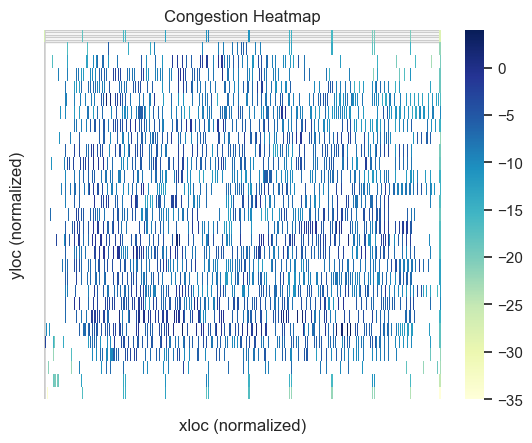

In [26]:
# create heaatmap normalizing the xloc and yloc
# Normalize xloc and yloc columns
instances['xloc_normalized'] = instances['xloc'] / instances['xloc'].max()
instances['yloc_normalized'] = instances['yloc'] / instances['yloc'].max()

# Create a pivot table to prepare data for heatmap
pivot_table = instances.pivot_table(index='yloc_normalized', columns='xloc_normalized', values='congestion')

# Create heatmap using seaborn
ax = sns.heatmap(pivot_table, cmap='YlGnBu')

# Set x-axis and y-axis ticks
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

# Add labels
plt.xlabel('xloc (normalized)')
plt.ylabel('yloc (normalized)')
plt.title('Congestion Heatmap')

# Show the plot
plt.show()

Text(0.5, 1.0, 'VLSI xbar1 Congestion Heatmap ')

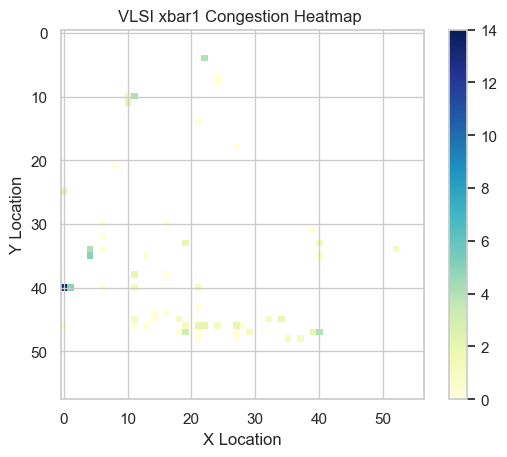

In [29]:
# Sum the values along the layer axis to obtain a 2D matrix
summed_matrix = np.sum(congestion, axis=0)

# Mask values below 0
masked_matrix = np.ma.masked_less(summed_matrix, 0)

# Create heatmap
plt.imshow(masked_matrix, cmap='YlGnBu', interpolation='nearest')

# Add color bar
plt.colorbar()

# Add labels
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('VLSI xbar1 Congestion Heatmap ')

# Show the plot

In [10]:
max_index, max_congestion

((47, 40), 4)

In [11]:
instances['congestion'].describe()

count    3952.000000
mean       -7.372470
std         4.116739
min       -35.000000
25%        -9.000000
50%        -7.000000
75%        -5.000000
max         4.000000
Name: congestion, dtype: float64

/opt/anaconda3/envs/DSC180-B07/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


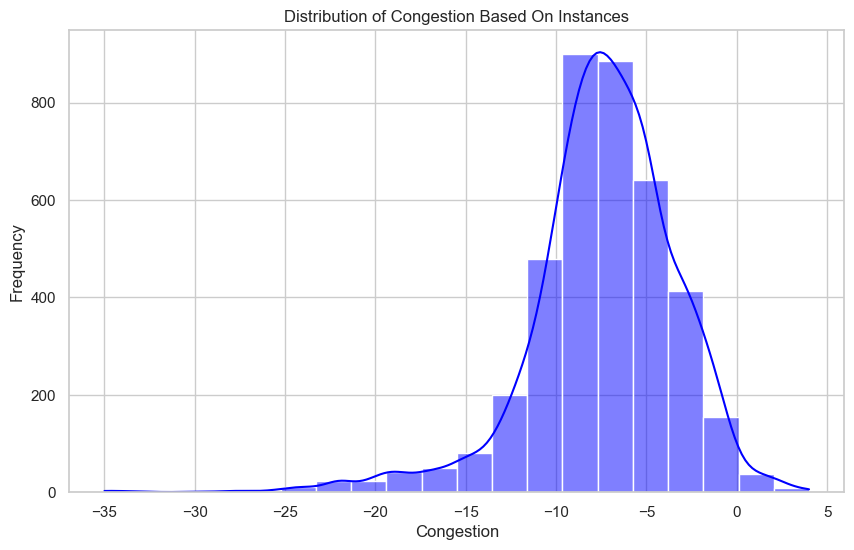

In [15]:
# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Create a distribution plot for the 'congestion' column
plt.figure(figsize=(10, 6))
sns.histplot(instances['congestion'], kde=True, color='blue', bins=20)  # Adjust the number of bins as needed
plt.title('Distribution of Congestion Based On Instances')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.show()

/opt/anaconda3/envs/DSC180-B07/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


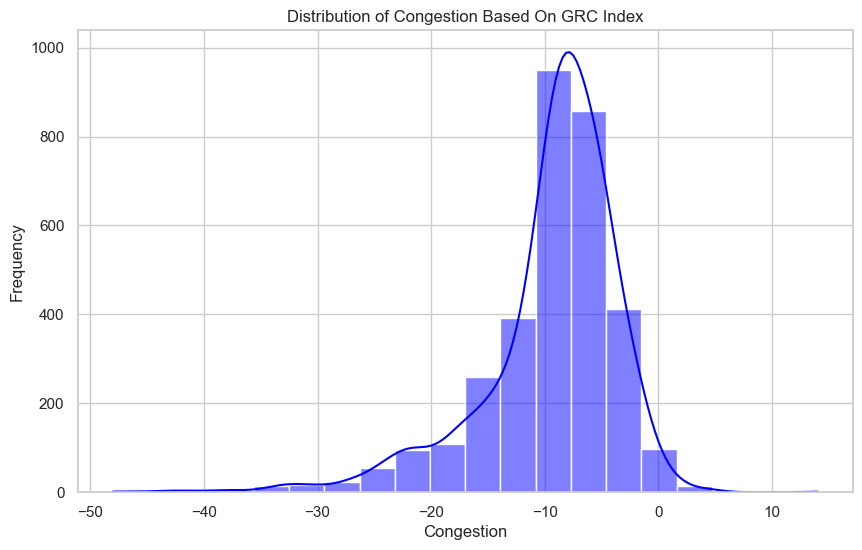

In [14]:
# Sum the values along the layer axis to obtain a 2D matrix
summed_matrix = np.sum(congestion, axis=0)

# Flatten the 2D matrix to create a 1D array of congestion values
flattened_congestion = summed_matrix.flatten()

# Plot the distribution of congestion values using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(flattened_congestion, kde=True, color='blue', bins=20)  # Adjust the number of bins as needed
plt.title('Distribution of Congestion Based On GRC Index')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.show()

In [16]:
summed_matrix

array([[-48, -44, -36, ..., -42, -30, -46],
       [-27, -24, -22, ..., -28, -18, -32],
       [-21, -19, -17, ..., -27, -14, -20],
       ...,
       [-24, -20, -19, ..., -25, -26, -33],
       [-32, -22, -20, ..., -28, -18, -33],
       [-42, -34, -33, ..., -35, -25, -37]])

In [17]:
# Convert the array to a pandas Series
arr_series = pd.Series(flattened_congestion)

# Use describe() to get summary statistics
arr_series.describe()

count    3306.000000
mean       -9.419540
std         6.122973
min       -48.000000
25%       -11.000000
50%        -8.000000
75%        -6.000000
max        14.000000
dtype: float64

In [18]:
summed_matrix[47][40]

4

In [19]:
np.where(summed_matrix == summed_matrix.max())

(array([40]), array([0]))

/opt/anaconda3/envs/DSC180-B07/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/DSC180-B07/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


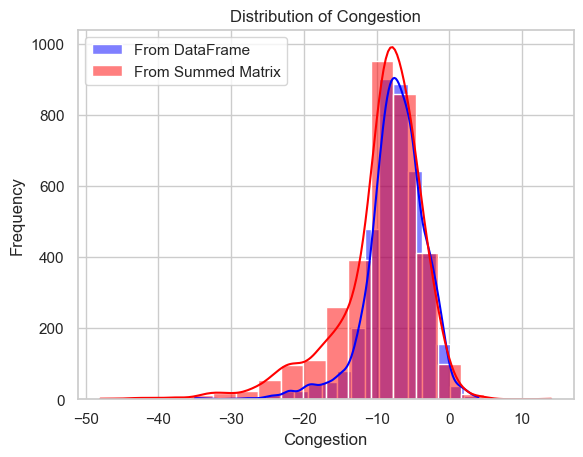

In [20]:
# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Create a distribution plot for the 'congestion' column from instances DataFrame
sns.histplot(instances['congestion'], kde=True, color='blue', bins=20, label='From DataFrame')

# Sum the values along the layer axis to obtain a 2D matrix
summed_matrix = np.sum(congestion, axis=0)

# Flatten the 2D matrix to create a 1D array of congestion values
flattened_congestion = summed_matrix.flatten()

# Create a distribution plot for the flattened congestion matrix
sns.histplot(flattened_congestion, kde=True, color='red', bins=20, label='From Summed Matrix')

# Set labels and title
plt.title('Distribution of Congestion')
plt.xlabel('Congestion')
plt.ylabel('Frequency')

# Add legend
plt.legend()

plt.show()


/var/folders/pj/rsjxx3fn6zsg1cc428gkfslh0000gn/T/ipykernel_52513/1794458286.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Spectral')


<Figure size 1500x1500 with 0 Axes>

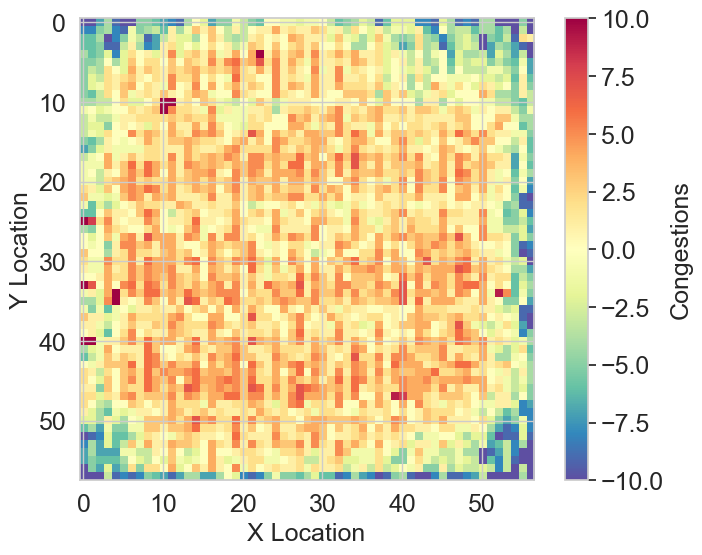

In [90]:
# Setting a larger figure size
plt.figure(figsize=(15, 15))

# Define the range of congestion values (-10 to 10)
min_congestion = -10
max_congestion = 10

# Normalize the congestion values between 0 and 1
norm = mcolors.Normalize(vmin=min_congestion, vmax=max_congestion)

# Get the 'Spectral' colormap
cmap = plt.cm.get_cmap('Spectral')
reversed_map = cmap.reversed()  # reversing the original colormap using reversed() function

# Create plot for Layer 1
plt.figure(figsize=(8, 6))
plt.imshow(congestion[1], cmap=reversed_map, norm=norm, interpolation='nearest')
colorbar = plt.colorbar(label='Congestions')
colorbar.set_label('Congestions', fontsize=18)
# Adjust font size for colorbar tick labels
colorbar.ax.tick_params(labelsize=18)
                        
plt.xlabel('X Location', fontsize=18)
plt.ylabel('Y Location', fontsize=18)
lay = congestion_data['layerList'][1]
# plt.title(f'VLSI Demand Heatmap - Layer {lay}')

# Adjust font size for x-axis and y-axis ticks
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

Instead of defining congest = demand - capacity, we can try demand/capacity to see if there's any difference in the plots.

/var/folders/pj/rsjxx3fn6zsg1cc428gkfslh0000gn/T/ipykernel_68326/2233835199.py:1: RuntimeWarning: invalid value encountered in divide
  congest_ratio = congestion_data['demand'] / congestion_data['capacity']
/var/folders/pj/rsjxx3fn6zsg1cc428gkfslh0000gn/T/ipykernel_68326/2233835199.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Spectral')


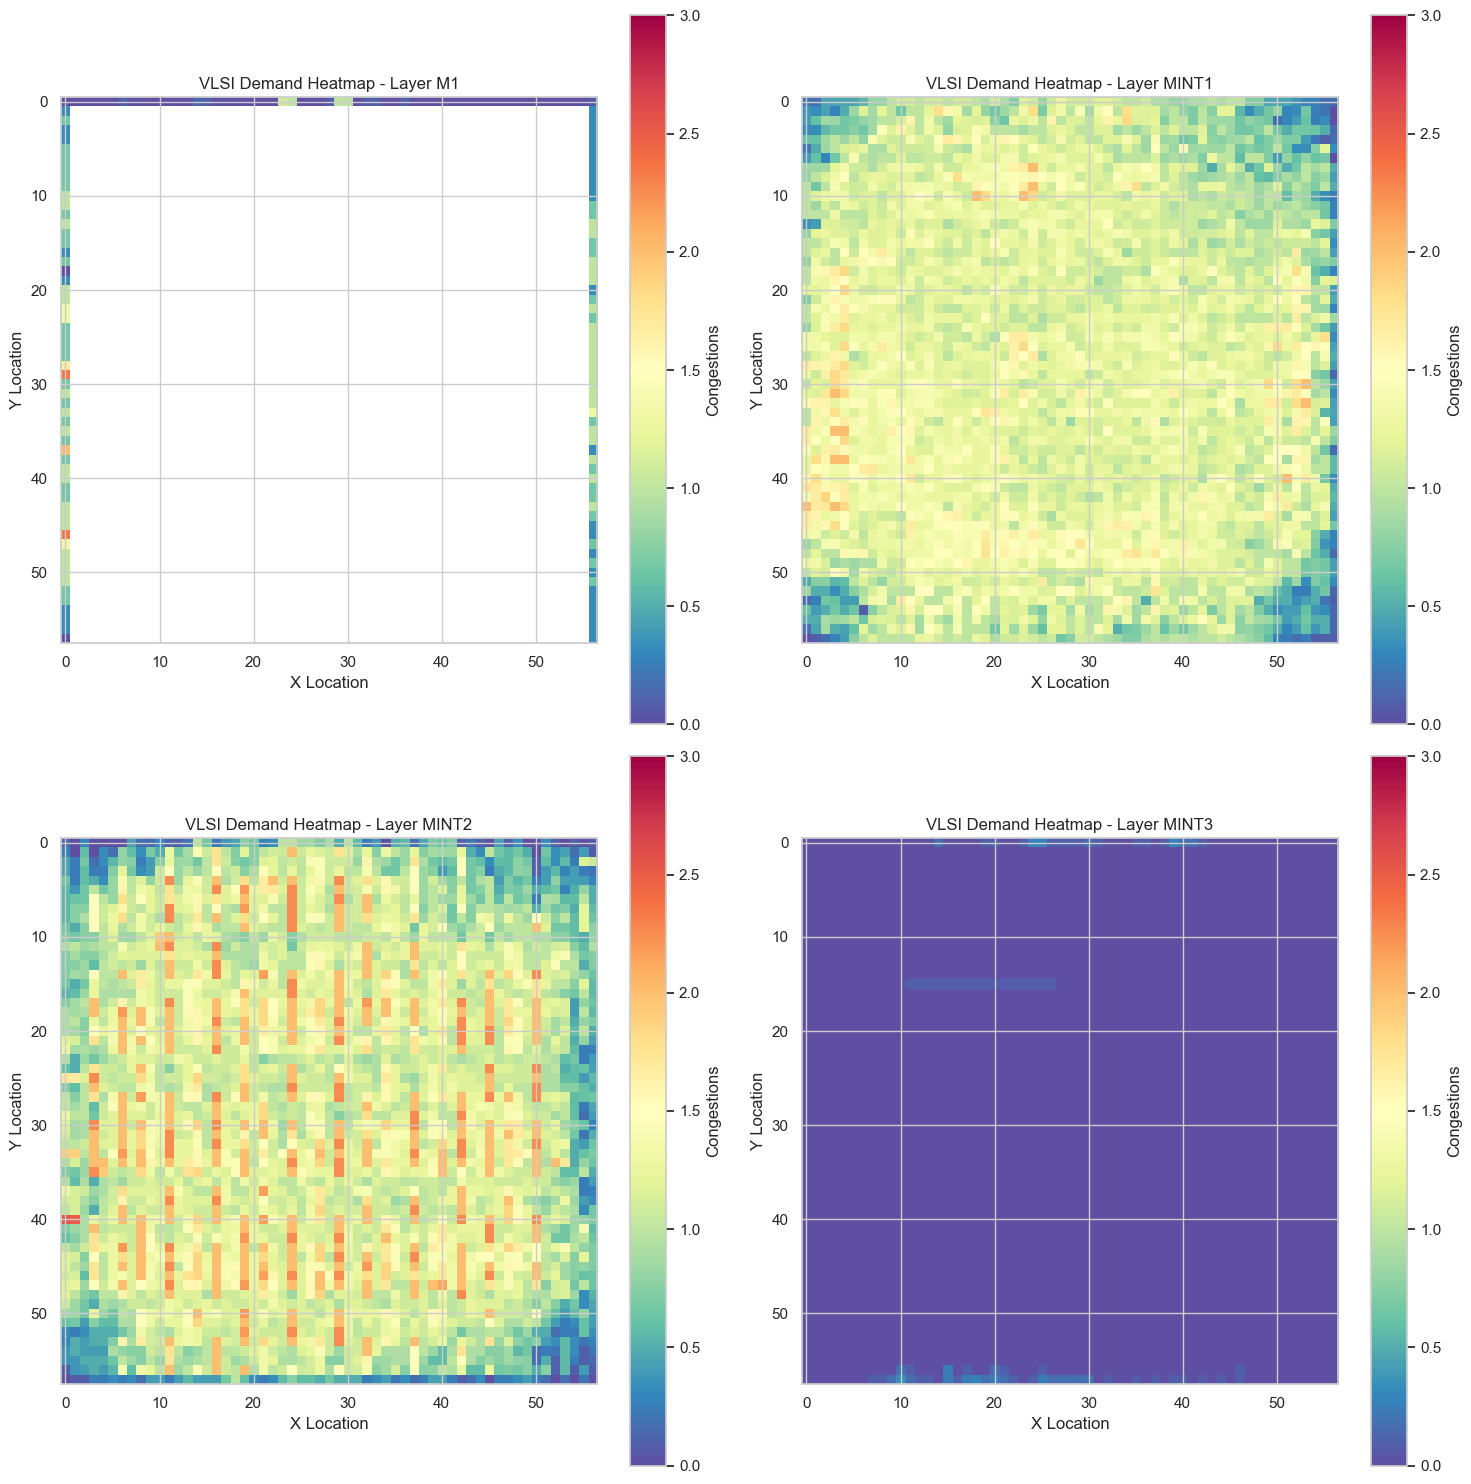

In [23]:
congest_ratio = congestion_data['demand'] / congestion_data['capacity']

# Setting a larger figure size
plt.figure(figsize=(15, 15))

# Define the range of congestion values (0 to 30)
min_congestion = 0
max_congestion = 3

# Normalize the congestion values between 0 and 1
norm = mcolors.Normalize(vmin=min_congestion, vmax=max_congestion)

# Get the 'Spectral' colormap
cmap = plt.cm.get_cmap('Spectral')
reversed_map = cmap.reversed()  # reversing the original colormap using reversed() function

# Create subplots
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(congest_ratio[i], cmap=reversed_map, norm = norm, interpolation='nearest')
    plt.colorbar(label='Congestions')
    plt.xlabel('X Location')
    plt.ylabel('Y Location')
    lay = congestion_data['layerList'][i]
    plt.title(f'VLSI Demand Heatmap - Layer {lay}')

plt.tight_layout()
plt.show()

In [24]:
# Flatten the congestion matrix
flattened_congestion = congestion.flatten()

# Find the indices of the top 3 maximum values in the flattened array
top_indices = np.argsort(flattened_congestion)[-5:][::-1]

# Get the congestion values corresponding to the top indices
top_values = flattened_congestion[top_indices]

# Create lists to store the results
top_highest_congestion = []
top_indices_layer = []
top_indices_xloc = []
top_indices_yloc = []

# Iterate over the sorted indices and collect all ties
for index in top_indices:
    congestion_value = flattened_congestion[index]
    if congestion_value in top_values:  # Check if it's one of the top values
        layer, flat_index = divmod(index, congestion.size // congestion.shape[0])
        xloc, yloc = np.unravel_index(flat_index, congestion[layer].shape)
        
        top_highest_congestion.append(congestion_value)
        top_indices_layer.append(layer)
        top_indices_xloc.append(xloc)
        top_indices_yloc.append(yloc)

# Create a DataFrame to store the results
top_congestion_df = pd.DataFrame({
    'Congestion Value': top_highest_congestion,
    'Layer': top_indices_layer,
    'X Location': top_indices_xloc,
    'Y Location': top_indices_yloc
})

top_congestion_df


,Congestion Value,Layer,X Location,Y Location
0,17,2,40,0
1,12,2,11,10
2,12,2,40,1
3,12,2,34,4
4,12,2,10,11


In [25]:
# Set NaN values to a large negative number to ignore them in the argmax calculation
congest_ratio[np.isnan(congest_ratio)] = -np.inf

# Flatten the congestion matrix
flattened_congestion = congest_ratio.flatten()

# Find the indices of the top 3 maximum values in the flattened array
top_indices = np.argsort(flattened_congestion)[-5:][::-1]

# Create lists to store the results
top_highest_congestion_ratio = []
top_indices_layer = []
top_indices_xloc = []
top_indices_yloc = []

# Iterate over the top 5 indices and extract the layer, x location, and y location
for index in top_indices:
    layer, flat_index = divmod(index, congest_ratio.size // congest_ratio.shape[0])
    xloc, yloc = np.unravel_index(flat_index, congest_ratio[layer].shape)
    
    top_highest_congestion_ratio.append(flattened_congestion[index])
    top_indices_layer.append(layer)
    top_indices_xloc.append(xloc)
    top_indices_yloc.append(yloc)

# Create a DataFrame to store the results
top_ratio_df = pd.DataFrame({
    'Congestion Ratio Value': top_highest_congestion_ratio,
    'Layer': top_indices_layer,
    'X Location': top_indices_xloc,
    'Y Location': top_indices_yloc
})

top_ratio_df


,Congestion Ratio Value,Layer,X Location,Y Location
0,2.545455,2,40,0
1,2.500000,2,40,1
2,2.333333,0,29,0
3,2.333333,0,46,0
4,2.250000,2,33,42


In [26]:
top_congestion_df, top_ratio_df

(   Congestion Value  Layer  X Location  Y Location
 0                17      2          40           0
 1                12      2          11          10
 2                12      2          40           1
 3                12      2          34           4
 4                12      2          10          11,
    Congestion Ratio Value  Layer  X Location  Y Location
 0                2.545455      2          40           0
 1                2.500000      2          40           1
 2                2.333333      0          29           0
 3                2.333333      0          46           0
 4                2.250000      2          33          42)

The provided data showcases congestion values and congestion ratio values along with their respective layers and spatial locations. Analysis of the congestion values reveals instances of high congestion, particularly in layer 2, with notable occurrences at x and y locations (40, 0) and (11, 10). Conversely, examination of the congestion ratio values indicates demand exceeding capacity, with layer 2 again featuring prominently, especially at x and y locations (40, 0) and (40, 1). Additionally, layer 0 exhibits significant congestion ratio values at x location 29 and x location 46, both at y location 0. These findings underscore the importance of considering both congestion and congestion ratio metrics for a comprehensive understanding of congestion dynamics across different layers and spatial locations. Further investigation into the underlying causes and potential mitigation strategies is warranted to address congestion hotspots effectively.

## All Datasets EDA

In [48]:
def gather_congestion_matrix(datasetNum):
    congestion_data = np.load(f'data/NCSU-DigIC-GraphData-2023-07-25/xbar/{datasetNum}/xbar_congestion.npz')
    congestion_matrix = congestion_data['demand'] - congestion_data['capacity']

    return congestion_matrix

In [49]:
def drawcongestion(datasetNum):
    congestion = gather_congestion_matrix(datasetNum)

    # Sum the values along the layer axis to obtain a 2D matrix
    summed_matrix = np.sum(congestion, axis=0)

    # Mask values below 0
    masked_matrix = np.ma.masked_less(summed_matrix, 0)

    # Create heatmap
    plt.imshow(masked_matrix, cmap='YlGnBu', interpolation='nearest')

    # Add color bar
    plt.colorbar()

    # Add labels
    plt.xlabel('X Location')
    plt.ylabel('Y Location')
    plt.title(f'VLSI xbar{datasetNum} Congestion Heatmap ')

    # Show the plot

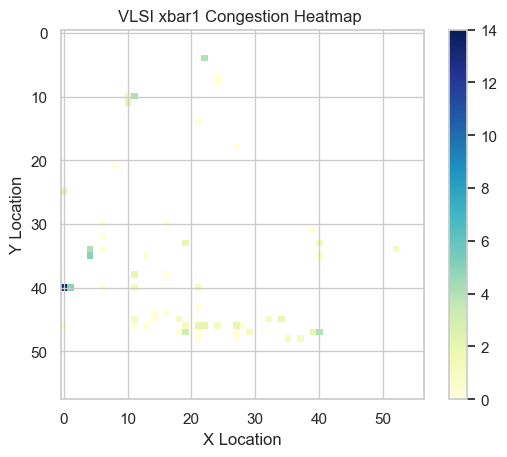

In [50]:
drawcongestion(1)

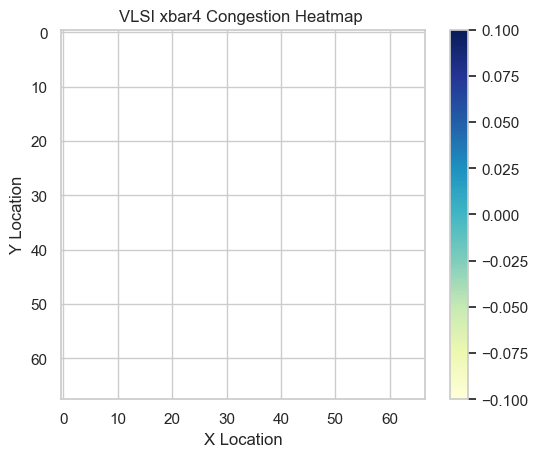

In [55]:
drawcongestion(4)

In [27]:
# Function to calculate distance between two points
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Dataset', 'Average Distance', 'Standard Deviation'])

for i in range(1, 14):  # Loop through xbar files numbered 1-13
    with gzip.open(f'NCSU-DigIC-GraphData-2023-07-25/xbar/{i}/xbar.json.gz', 'rb') as f:
        design = json.loads(f.read().decode('utf-8'))
    instances = pd.DataFrame(design['instances'])
    
    # Calculate distances between all pairs of points
    distances = []
    for j in range(len(instances)):
        for k in range(j+1, len(instances)):
            x1, y1 = instances.loc[j, 'xloc'], instances.loc[j, 'yloc']
            x2, y2 = instances.loc[k, 'xloc'], instances.loc[k, 'yloc']
            distances.append(calculate_distance(x1, y1, x2, y2))
    
    # Calculate average and standard deviation of distances
    average_distance = np.mean(distances)
    std_dev_distance = np.std(distances)
    
    
    # Add results to the DataFrame
    results_df = results_df.append({'Dataset': i, 'Average Distance': average_distance, 'Standard Deviation': std_dev_distance}, ignore_index=True)

    print(f'xbar{i} finished')
    
print(results_df)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
results_df

,Dataset,Average Distance,Standard Deviation
0,1.0,39370.111189,18920.224152
1,2.0,44706.209726,21235.245083
2,3.0,44316.495634,21184.924479
3,4.0,48670.785214,23228.202184
4,5.0,48489.829416,23162.838743
5,6.0,46505.175835,22247.450330
6,7.0,53799.481300,25608.021452
7,8.0,53007.283328,25348.230865
8,9.0,51677.482110,24605.473379
9,10.0,53856.309735,25626.809595


In [ ]:
connections_df = pd.DataFrame(columns=['Dataset', 'Average Connections', 'Standard Deviation'])

for i in range(1, 14):  # Loop through xbar files numbered 1-13
    with gzip.open(f'NCSU-DigIC-GraphData-2023-07-25/xbar/{i}/xbar.json.gz', 'rb') as f:
        design = json.loads(f.read().decode('utf-8'))
    instances = pd.DataFrame(design['instances'])

    # Load adjacency matrix
    conn = np.load(f'NCSU-DigIC-GraphData-2023-07-25/xbar/{i}/xbar_connectivity.npz')
    A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
    A = A.__mul__(A.T)

    # Flatten the upper triangle of the adjacency matrix (excluding the diagonal)
    connections = A[np.triu_indices(A.shape[0], k=1)]

    # Calculate average and standard deviation of connection counts
    average_connections = np.mean(connections)
    std_dev_connections = np.std(connections)

    # Add results to the DataFrame
    connections_df = connections_df.append({'Dataset': i, 'Average Connections': average_connections, 'Standard Deviation': std_dev_connections}, ignore_index=True)

    print(f'xbar{i} finished')
connections_df

xbar1 finished
xbar2 finished
xbar3 finished
xbar4 finished
xbar5 finished
xbar6 finished
xbar7 finished
xbar8 finished
xbar9 finished
xbar10 finished
xbar11 finished
xbar12 finished
xbar13 finished


,Dataset,Average Connections,Standard Deviation
0,1.0,0.135479,1.572937
1,2.0,0.019842,0.575010
2,3.0,0.019889,0.559839
3,4.0,0.015994,0.503863
4,5.0,0.016263,0.503446
5,6.0,0.015215,0.467519
6,7.0,0.013039,0.440111
7,8.0,0.014354,0.466577
8,9.0,0.013850,0.451614
9,10.0,0.013485,0.448963


In [ ]:
instances.groupby('cell').count()

,name,id,xloc,yloc,orient
cell,,,,,
0,48,48,48,48,48
9,1152,1152,1152,1152,1152
11,2,2,2,2,2
23,12,12,12,12,12
34,254,254,254,254,254
42,84,84,84,84,84
46,396,396,396,396,396
48,35,35,35,35,35
49,1,1,1,1,1


In [ ]:
# Initialize an empty DataFrame to store the results
num_connections_df = pd.DataFrame()

for i in range(1, 14):  # Loop through xbar files numbered 1-13
    with gzip.open(f'NCSU-DigIC-GraphData-2023-07-25/xbar/{i}/xbar.json.gz', 'rb') as f:
        design = json.loads(f.read().decode('utf-8'))
    instances = pd.DataFrame(design['instances'])

    # Load adjacency matrix
    conn = np.load(f'NCSU-DigIC-GraphData-2023-07-25/xbar/{i}/xbar_connectivity.npz')
    A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
    A = A.__mul__(A.T)
    
    # Initialize dictionary to store connections per cell type for the current file
    connections_per_cell = {cell: 0 for cell in instances['cell'].unique()}
    
    # Iterate over unique cell types in the current file
    for cell in instances['cell'].unique():
        # Get node IDs corresponding to the current cell type
        node_ids = list(instances[instances['cell'] == cell]['id'])

        total = 0
        # Calculate connections for each node
        for node_id in node_ids:
            # Get the row of the adjacency matrix corresponding to the current node
            row = A.toarray()[node_id]
            total += np.sum(row[node_ids])
        
        # Store total connections for the current cell type
        connections_per_cell[cell] = total
    
    # Convert dictionary to DataFrame with a single row representing the current file
    df_row = pd.DataFrame.from_dict(connections_per_cell, orient='index').T
    
    # Append the row to the DataFrame
    num_connections_df = num_connections_df.append(df_row, ignore_index=True)

    print(f'xbar{i} finished')
    

# Fill NaN values with zeros (for cell types not present in some files)
num_connections_df.fillna(0, inplace=True)

# Convert any floating point values to integers
num_connections_df = num_connections_df.astype(int)

print(num_connections_df)

xbar1 finished
xbar2 finished
xbar3 finished
xbar4 finished
xbar5 finished
xbar6 finished
xbar7 finished
xbar8 finished
xbar9 finished
xbar10 finished
xbar11 finished
xbar12 finished
xbar13 finished
      0     1    2   3    4     7    8       9    10  11  ...   55      56  \
0   1536     0    0   0    0     0    0  870108    0  14  ...    0  876468   
1   2492   324  270   0   55  1348    0  119078    0  60  ...    0  324601   
2   2074   470   60   0    0  2758   30  138571  142  40  ...   30  275359   
3   1962   790  270  30   55  4134   60   77483    0  10  ...   30  230937   
4   1712   714  480  60   55  3452   30   78390    0   5  ...   60  244440   
5   1914  1012  300   0    0  3826  120  100419    0  35  ...    0  241246   
6   2318   794  510   0  220  4134  120   85068  293  25  ...   60  194082   
7   2084  1084  240  60  275  2428   30   85376  220  40  ...   60  222731   
8   2368   700  180  30  110  3076   90   88183  110  59  ...   90  238174   
9   2974   510  420  

In [ ]:
num_connections_df

,0,1,2,3,4,7,8,9,10,11,...,55,56,57,58,59,60,61,62,64,65
0,1536,0,0,0,0,0,0,870108,0,14,...,0,876468,0,0,0,0,0,0,0,325452
1,2492,324,270,0,55,1348,0,119078,0,60,...,0,324601,110,782,42,0,0,0,410304,0
2,2074,470,60,0,0,2758,30,138571,142,40,...,30,275359,110,2108,228,30,0,0,390595,4267
3,1962,790,270,30,55,4134,60,77483,0,10,...,30,230937,440,738,282,30,60,0,389863,2543
4,1712,714,480,60,55,3452,30,78390,0,5,...,60,244440,775,840,304,0,0,55,377715,2543
5,1914,1012,300,0,0,3826,120,100419,0,35,...,0,241246,110,918,222,30,30,110,280571,3867
6,2318,794,510,0,220,4134,120,85068,293,25,...,60,194082,715,1640,262,120,30,220,350231,4007
7,2084,1084,240,60,275,2428,30,85376,220,40,...,60,222731,607,1292,266,60,60,275,367879,4079
8,2368,700,180,30,110,3076,90,88183,110,59,...,90,238174,451,1544,98,0,0,0,330894,1031
9,2974,510,420,30,110,3300,180,66327,55,49,...,150,220447,220,1740,92,196,0,220,355565,3951
